![Team USA Football](images/Usa_football_body_logo.png)

### Overview

This projects mission was to build a model that can determine what contributes to a football players sucess on the field.

### Business Understanding

Foxy Stats was hired to perform data analysis for Team USA. Flag Football is coming to the 2028 Olympic Games in LA and they need the best our country has to offer. While the NFL is full contact
they are still some of the players in the United States. We are to find the best of the best to help fill in some gaps in the team 

### Data Understanding and Limitations
The data comes from nflverse via their [GitHub](https://github.com/nflverse/nflverse-data/releases). The initial data contains offensive stats from 1999 to 2023. It is updated on a weekly basis during the football season and after any stat is corrected as well.  

Data Dictionary available to help better understand these stats [here](https://nflreadr.nflverse.com/articles/dictionary_player_stats.html)

Limitations include no record of win or loss. No record of defensive stats to paint a fuller picture. No record of lineman performance upon a sack or rushing negative yards, fumble, etc  

### Table of Contents
- Exploratory Data Analysis
    - Feature Engineering
- Modeling and Evaluating
    - DecisionTree
    - Random Forest Classifier (RFC)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ill save my data as some new dataframes and see what i have.

In [2]:
stats_df = pd.read_csv('data/player_stats.csv')

ill start with stats_df as that will require more work

In [3]:
stats_df.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,1,REG,...,0,0.292378,0,0.0,0.052632,NaN,NaN,0,12.7,13.7
1,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,2,REG,...,1,0.377009,0,0.0,0.117647,NaN,NaN,0,5.1,8.1
2,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,4,REG,...,0,-0.699578,0,NaN,0.023810,NaN,NaN,0,0.2,0.2
3,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,7,REG,...,0,-0.228454,0,0.0,0.050000,NaN,NaN,0,3.5,5.5
4,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,8,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,3.9,3.9


In [4]:
# lets check up on Aaron Rodgers
stats_df[stats_df['player_display_name'] == 'Aaron Rodgers'].head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
34491,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,GB,2005,5,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,0.00,0.00
34492,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,GB,2005,15,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,-2.60,-2.60
34493,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,GB,2005,17,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,-0.10,-0.10
38709,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,GB,2006,4,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,0.56,0.56
38710,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,GB,2006,11,REG,...,0,NaN,0,NaN,NaN,NaN,NaN,0,0.38,0.38


In [5]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129739 entries, 0 to 129738
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    129739 non-null  object 
 1   player_name                  61504 non-null   object 
 2   player_display_name          129736 non-null  object 
 3   position                     129667 non-null  object 
 4   position_group               129667 non-null  object 
 5   headshot_url                 69803 non-null   object 
 6   recent_team                  129739 non-null  object 
 7   season                       129739 non-null  int64  
 8   week                         129739 non-null  int64  
 9   season_type                  129739 non-null  object 
 10  opponent_team                129739 non-null  object 
 11  completions                  129739 non-null  int64  
 12  attempts                     129739 non-null  int64  
 13 

In [6]:
stats_df['position'].value_counts()

WR     49363
RB     33350
TE     24147
QB     16086
FB      5219
P        459
CB       148
G        128
DB       123
T         94
FS        93
SS        77
LS        56
OLB       56
K         46
LB        45
ILB       32
DE        28
C         28
DT        20
OT        17
DL        15
HB        13
NT        10
MLB        8
OG         3
OL         2
S          1
Name: position, dtype: int64

ive only got offensive related stats going back to 1999. I wont be needing those older players in a team for today

In [7]:
# look at the last ten years of data 
stats_df = stats_df[stats_df['season'].isin(range(2014, 2024))]

In [8]:
# look at the regular season so we can see every player in action. this is about players not teams
stats_df = stats_df[stats_df['season_type'] == 'REG']


In [9]:
#working solely with the offense seperate by position for our 3 analyses
# Filter for quarterbacks
qbs_df = stats_df[stats_df['position'] == 'QB']

# Filter for rushers (RBs and FBs)
rushers_df = stats_df[stats_df['position'].isin(['RB', 'FB', 'HB'])]

# Filter for receivers (WRs and TEs)
receivers_df = stats_df[stats_df['position'].isin(['WR', 'TE'])]

In [10]:
# QB metrics
qbs_df.loc[:, 'completion_percentage'] = (qbs_df['completions'] / qbs_df['attempts']) * 100
qbs_df.loc[:, 'yards_per_attempt'] = qbs_df['passing_yards'] / qbs_df['attempts']
qbs_df.loc[:, 'pass_tds_per_attempt'] = qbs_df['passing_tds'] / qbs_df['attempts']
qbs_df.loc[:, 'season_passing_yards'] = qbs_df.groupby(['player_id', 'season'])['passing_yards'].transform('sum')
qbs_df.loc[:, 'season_passing_tds'] = qbs_df.groupby(['player_id', 'season'])['passing_tds'].transform('sum')
qbs_df.loc[:, 'season_pass_attempts'] = qbs_df.groupby(['player_id', 'season'])['attempts'].transform('sum')
qbs_df.loc[:, 'season_completions'] = qbs_df.groupby(['player_id', 'season'])['completions'].transform('sum')
qbs_df.loc[:, 'season_completion_percentage'] = qbs_df.groupby(['player_id', 'season'])['completion_percentage'].transform('mean')
qbs_df.loc[:, 'season_yards_per_attempt'] = qbs_df.groupby(['player_id', 'season'])['yards_per_attempt'].transform('mean')
qbs_df.loc[:, 'season_pass_tds_per_attempt'] = qbs_df.groupby(['player_id', 'season'])['pass_tds_per_attempt'].transform('mean')

# Rusher metrics
rushers_df.loc[:, 'yards_per_carry'] = rushers_df['rushing_yards'] / rushers_df['carries']
rushers_df.loc[:, 'tds_per_carry'] = (rushers_df['rushing_tds'] / rushers_df['carries']) * 100
rushers_df.loc[:, 'season_rushing_tds'] = rushers_df.groupby(['player_id', 'season'])['rushing_tds'].transform('sum')
rushers_df.loc[:, 'season_rushing_yards'] = rushers_df.groupby(['player_id', 'season'])['rushing_yards'].transform('sum')
rushers_df.loc[:, 'season_carries'] = rushers_df.groupby(['player_id', 'season'])['carries'].transform('sum')
rushers_df.loc[:, 'season_yards_per_carry'] = rushers_df.groupby(['player_id', 'season'])['yards_per_carry'].transform('mean')
rushers_df.loc[:, 'season_tds_per_carry'] = rushers_df.groupby(['player_id', 'season'])['tds_per_carry'].transform('mean')

# Receiver metrics
receivers_df.loc[:, 'yards_per_reception'] = receivers_df['receiving_yards'] / receivers_df['receptions']
receivers_df.loc[:, 'season_receiving_yards'] = receivers_df.groupby(['player_id', 'season'])['receiving_yards'].transform('sum')
receivers_df.loc[:, 'tds_per_reception'] = (receivers_df['receiving_tds'] / receivers_df['receptions']) * 100
receivers_df.loc[:, 'season_receiving_tds'] = receivers_df.groupby(['player_id', 'season'])['receiving_tds'].transform('sum')
receivers_df.loc[:, 'season_receptions'] = receivers_df.groupby(['player_id', 'season'])['receptions'].transform('sum')
receivers_df.loc[:, 'season_yards_per_reception'] = receivers_df.groupby(['player_id', 'season'])['yards_per_reception'].transform('mean')
receivers_df.loc[:, 'season_tds_per_reception'] = receivers_df.groupby(['player_id', 'season'])['tds_per_reception'].transform('mean')

c:\Users\Trugrit\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Trugrit\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Qbs

In [11]:
qbs_df = qbs_df.drop(columns= ['player_id',
                               'player_name',
                               'position', 
                               'position_group',
                               'headshot_url',
                               'season_type',   
                               'passing_epa',
                               'pacr',
                               'dakota',
                               'attempts',
                               'completions',
                               'passing_yards',
                               'passing_tds',
                               'interceptions',
                               'sacks',
                               'sack_yards',
                               'sack_fumbles',
                               'sack_fumbles_lost',
                               'passing_air_yards',
                               'passing_yards_after_catch',
                               'passing_first_downs',
                               'passing_epa',
                               'passing_2pt_conversions',
                               'carries',
                               'rushing_yards',
                               'rushing_tds',
                               'rushing_fumbles',
                               'rushing_fumbles_lost',
                               'rushing_first_downs',
                               'rushing_epa',
                               'rushing_2pt_conversions',
                               'receptions',
                               'targets',
                               'receiving_yards',
                               'receiving_tds',
                               'receiving_fumbles',
                               'receiving_fumbles_lost',
                               'receiving_air_yards',
                               'receiving_yards_after_catch',
                               'receiving_first_downs',
                               'receiving_epa',
                               'receiving_2pt_conversions',
                               'racr',
                               'target_share',
                               'air_yards_share',
                               'wopr',
                               'special_teams_tds',
                               'fantasy_points',
                               'fantasy_points_ppr'
                              ]).reset_index(drop=True)
qbs_df.head()

,player_display_name,recent_team,season,week,opponent_team,completion_percentage,yards_per_attempt,pass_tds_per_attempt,season_passing_yards,season_passing_tds,season_pass_attempts,season_completions,season_completion_percentage,season_yards_per_attempt,season_pass_tds_per_attempt
0,Matt Hasselbeck,IND,2014,3,JAX,50.000000,5.000000,0.000000,301,2,44,30,63.283208,6.385965,0.033417
1,Matt Hasselbeck,IND,2014,4,TEN,NaN,NaN,NaN,301,2,44,30,63.283208,6.385965,0.033417
2,Matt Hasselbeck,IND,2014,16,DAL,71.428571,6.000000,0.047619,301,2,44,30,63.283208,6.385965,0.033417
3,Matt Hasselbeck,IND,2014,17,TEN,68.421053,8.157895,0.052632,301,2,44,30,63.283208,6.385965,0.033417
4,Peyton Manning,DEN,2014,1,IND,61.111111,7.472222,0.083333,4727,39,597,395,67.329592,8.169275,0.068182


In [12]:
# Get the index of the maximum week for each player
max_week_idx = qbs_df.groupby(['player_display_name', 'season'])['week'].idxmax()

# Select the rows corresponding to these indices
qbs_df = qbs_df.loc[max_week_idx].reset_index(drop=True)
qbs_df = qbs_df.drop(columns= 'week')
qbs_df.head()

,player_display_name,recent_team,season,opponent_team,completion_percentage,yards_per_attempt,pass_tds_per_attempt,season_passing_yards,season_passing_tds,season_pass_attempts,season_completions,season_completion_percentage,season_yards_per_attempt,season_pass_tds_per_attempt
0,AJ McCarron,CIN,2015,BAL,62.962963,5.925926,0.074074,854,6,119,79,72.110891,6.477734,0.035461
1,AJ McCarron,CIN,2017,MIN,50.000000,3.166667,0.000000,66,0,14,7,50.000000,4.520833,0.000000
2,AJ McCarron,LV,2018,BAL,NaN,NaN,NaN,8,0,3,1,33.333333,2.666667,0.000000
3,AJ McCarron,HOU,2019,TEN,58.333333,6.250000,0.000000,225,0,37,21,29.166667,3.125000,0.000000
4,AJ McCarron,HOU,2020,TEN,100.000000,20.000000,0.000000,20,0,1,1,100.000000,20.000000,0.000000


In [13]:
qbs_df = qbs_df.dropna(subset=['completion_percentage'])

In [14]:
qbs_df = qbs_df[qbs_df['season_pass_attempts'] >= 100]
qbs_df.drop(columns=['recent_team', 'opponent_team', 'completion_percentage', 'yards_per_attempt', 'pass_tds_per_attempt'], inplace=True)

In [15]:
qbs_df.head()

,player_display_name,season,season_passing_yards,season_passing_tds,season_pass_attempts,season_completions,season_completion_percentage,season_yards_per_attempt,season_pass_tds_per_attempt
0,AJ McCarron,2015,854,6,119,79,72.110891,6.477734,0.035461
6,Aaron Rodgers,2014,4381,38,520,341,66.956848,8.641434,0.082370
7,Aaron Rodgers,2015,3821,31,572,347,61.519115,6.733264,0.055985
8,Aaron Rodgers,2016,4428,40,610,401,65.990423,7.421580,0.069920
9,Aaron Rodgers,2017,1675,16,238,154,63.122732,6.738127,0.065600


In [16]:
qbs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 768
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   player_display_name           428 non-null    object 
 1   season                        428 non-null    int64  
 2   season_passing_yards          428 non-null    int64  
 3   season_passing_tds            428 non-null    int64  
 4   season_pass_attempts          428 non-null    int64  
 5   season_completions            428 non-null    int64  
 6   season_completion_percentage  428 non-null    float64
 7   season_yards_per_attempt      428 non-null    float64
 8   season_pass_tds_per_attempt   428 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 33.4+ KB


## Rushers

In [17]:
rushers_df = rushers_df.drop(columns= ['player_id',
                                       'player_name',
                                       'position', 
                                       'position_group',
                                       'headshot_url',
                                       'season_type',
                                       'passing_epa',
                                       'pacr',
                                       'dakota',
                                       'completions',
                                       'attempts',
                                       'passing_yards',
                                       'passing_tds',
                                       'interceptions',
                                       'sacks',
                                       'sack_yards',
                                       'sack_fumbles',
                                       'sack_fumbles_lost',
                                       'passing_air_yards',
                                       'passing_yards_after_catch',
                                       'passing_first_downs',
                                       'passing_epa',
                                       'passing_2pt_conversions',
                                       'rushing_epa',
                                       'receptions',
                                       'targets',
                                       'receiving_yards',
                                       'receiving_tds',
                                       'receiving_fumbles',
                                       'receiving_fumbles_lost',
                                       'receiving_air_yards',
                                       'receiving_yards_after_catch',
                                       'receiving_first_downs',
                                       'receiving_epa',
                                       'receiving_2pt_conversions',
                                       'racr',
                                       'target_share',
                                       'air_yards_share',
                                       'wopr',
                                       'special_teams_tds',
                                       'fantasy_points',
                                       'fantasy_points_ppr'
                                      ]).reset_index(drop=True)

rushers_df.head()

,player_display_name,recent_team,season,week,opponent_team,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_2pt_conversions,yards_per_carry,tds_per_carry,season_rushing_tds,season_rushing_yards,season_carries,season_yards_per_carry,season_tds_per_carry
0,Steven Jackson,ATL,2014,1,NO,12,52,0,0,0,2,0,4.333333,0.000000,6,707,190,3.633017,2.705535
1,Steven Jackson,ATL,2014,2,CIN,11,46,0,0,0,2,0,4.181818,0.000000,6,707,190,3.633017,2.705535
2,Steven Jackson,ATL,2014,3,TB,14,54,1,0,0,5,0,3.857143,7.142857,6,707,190,3.633017,2.705535
3,Steven Jackson,ATL,2014,4,MIN,13,49,0,0,0,3,0,3.769231,0.000000,6,707,190,3.633017,2.705535
4,Steven Jackson,ATL,2014,5,NYG,13,37,1,0,0,3,0,2.846154,7.692308,6,707,190,3.633017,2.705535


In [18]:
rushers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14451 entries, 0 to 14450
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_display_name      14451 non-null  object 
 1   recent_team              14451 non-null  object 
 2   season                   14451 non-null  int64  
 3   week                     14451 non-null  int64  
 4   opponent_team            14451 non-null  object 
 5   carries                  14451 non-null  int64  
 6   rushing_yards            14451 non-null  int64  
 7   rushing_tds              14451 non-null  int64  
 8   rushing_fumbles          14451 non-null  int64  
 9   rushing_fumbles_lost     14451 non-null  int64  
 10  rushing_first_downs      14451 non-null  int64  
 11  rushing_2pt_conversions  14451 non-null  int64  
 12  yards_per_carry          12959 non-null  float64
 13  tds_per_carry            12959 non-null  float64
 14  season_rushing_tds    

In [19]:
# Get the index of the maximum week for each player
max_week_idx = rushers_df.groupby(['player_display_name', 'season'])['week'].idxmax()

# Select the rows corresponding to these indices
rushers_df = rushers_df.loc[max_week_idx].reset_index(drop=True)
rushers_df = rushers_df.drop(columns= 'week')
rushers_df.head()

,player_display_name,recent_team,season,opponent_team,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_2pt_conversions,yards_per_carry,tds_per_carry,season_rushing_tds,season_rushing_yards,season_carries,season_yards_per_carry,season_tds_per_carry
0,A.J. Dillon,GB,2020,CHI,1,3,0,0,0,0,0,3.000000,0.0,2,242,46,5.878307,1.058201
1,A.J. Dillon,GB,2021,DET,14,63,0,0,0,3,0,4.500000,0.0,5,803,187,4.195966,2.240896
2,A.J. Dillon,GB,2022,DET,9,33,0,0,0,3,0,3.666667,0.0,7,770,186,4.165845,3.744801
3,A.J. Dillon,GB,2023,MIN,7,27,0,0,0,1,0,3.857143,0.0,2,613,178,3.370240,1.285714
4,Aaron Jones,GB,2017,MIN,3,13,0,0,0,0,0,4.333333,0.0,4,448,81,6.710791,11.883782


In [20]:
rushers_df = rushers_df[rushers_df['season_carries'] >= 100]
rushers_df.drop(columns=['recent_team', 'opponent_team', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_2pt_conversions', 'yards_per_carry', 'tds_per_carry'], inplace=True)

In [21]:
rushers_df.head()

,player_display_name,season,season_rushing_tds,season_rushing_yards,season_carries,season_yards_per_carry,season_tds_per_carry
1,A.J. Dillon,2021,5,803,187,4.195966,2.240896
2,A.J. Dillon,2022,7,770,186,4.165845,3.744801
3,A.J. Dillon,2023,2,613,178,3.370240,1.285714
5,Aaron Jones,2018,8,728,133,5.305956,5.058675
6,Aaron Jones,2019,16,1084,236,4.327544,6.656247


In [22]:
rushers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 1 to 1600
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_display_name     455 non-null    object 
 1   season                  455 non-null    int64  
 2   season_rushing_tds      455 non-null    int64  
 3   season_rushing_yards    455 non-null    int64  
 4   season_carries          455 non-null    int64  
 5   season_yards_per_carry  455 non-null    float64
 6   season_tds_per_carry    455 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 28.4+ KB


## Receivers

In [23]:
receivers_df = receivers_df.drop(columns= ['player_id',
                                           'player_name',
                                           'position', 
                                           'position_group',
                                           'headshot_url',
                                           'season_type',
                                           'passing_epa',
                                           'pacr',
                                           'dakota',
                                           'completions',
                                           'attempts',
                                           'passing_yards',
                                           'passing_tds',
                                           'interceptions',
                                           'sacks',
                                           'sack_yards',
                                           'sack_fumbles',
                                           'sack_fumbles_lost',
                                           'passing_air_yards',
                                           'passing_yards_after_catch',
                                           'passing_first_downs',
                                           'passing_epa',
                                           'passing_2pt_conversions',
                                           'carries',
                                           'rushing_yards',
                                           'rushing_tds',
                                           'rushing_fumbles',
                                           'rushing_fumbles_lost',
                                           'rushing_first_downs',
                                           'rushing_epa',
                                           'rushing_2pt_conversions',
                                           'receiving_epa',
                                           'racr',
                                           'target_share',
                                           'air_yards_share',
                                           'wopr',
                                           'special_teams_tds',
                                           'fantasy_points',
                                           'fantasy_points_ppr'
                                          ]).reset_index(drop=True)

receivers_df.head()

,player_display_name,recent_team,season,week,opponent_team,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,...,receiving_yards_after_catch,receiving_first_downs,receiving_2pt_conversions,yards_per_reception,season_receiving_yards,tds_per_reception,season_receiving_tds,season_receptions,season_yards_per_reception,season_tds_per_reception
0,Steve Smith,BAL,2014,1,CIN,7,15,118,1,0,...,51,3,0,16.857143,1065,14.285714,6,79,12.944643,6.383929
1,Steve Smith,BAL,2014,2,PIT,6,10,71,0,0,...,45,4,0,11.833333,1065,0.000000,6,79,12.944643,6.383929
2,Steve Smith,BAL,2014,3,CLE,5,7,101,0,0,...,25,3,0,20.200000,1065,0.000000,6,79,12.944643,6.383929
3,Steve Smith,BAL,2014,4,CAR,7,10,139,2,0,...,69,6,0,19.857143,1065,28.571429,6,79,12.944643,6.383929
4,Steve Smith,BAL,2014,5,IND,5,7,34,0,1,...,7,1,0,6.800000,1065,0.000000,6,79,12.944643,6.383929


In [24]:
receivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30802 entries, 0 to 30801
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_display_name          30802 non-null  object 
 1   recent_team                  30802 non-null  object 
 2   season                       30802 non-null  int64  
 3   week                         30802 non-null  int64  
 4   opponent_team                30802 non-null  object 
 5   receptions                   30802 non-null  int64  
 6   targets                      30802 non-null  int64  
 7   receiving_yards              30802 non-null  int64  
 8   receiving_tds                30802 non-null  int64  
 9   receiving_fumbles            30802 non-null  int64  
 10  receiving_fumbles_lost       30802 non-null  int64  
 11  receiving_air_yards          30802 non-null  int64  
 12  receiving_yards_after_catch  30802 non-null  int64  
 13  receiving_first_

In [25]:
# Get the index of the maximum week for each player
max_week_idx = receivers_df.groupby(['player_display_name', 'season'])['week'].idxmax()

# Select the rows corresponding to these indices
receivers_df = receivers_df.loc[max_week_idx].reset_index(drop=True)
receivers_df = receivers_df.drop(columns= 'week')
receivers_df.head()

,player_display_name,recent_team,season,opponent_team,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,...,receiving_yards_after_catch,receiving_first_downs,receiving_2pt_conversions,yards_per_reception,season_receiving_yards,tds_per_reception,season_receiving_tds,season_receptions,season_yards_per_reception,season_tds_per_reception
0,A.J. Brown,TEN,2019,HOU,4,8,124,1,0,0,...,53,3,0,31.00,1051,25.0,8,52,19.626042,13.697917
1,A.J. Brown,TEN,2020,HOU,10,11,151,1,0,0,...,39,7,0,15.10,1075,10.0,11,70,15.804592,15.374150
2,A.J. Brown,TEN,2021,HOU,4,6,68,1,0,0,...,25,4,0,17.00,869,25.0,5,63,14.088068,6.799242
3,A.J. Brown,PHI,2022,NYG,4,10,95,0,0,0,...,34,4,0,23.75,1496,0.0,11,88,16.368791,12.647059
4,A.J. Brown,PHI,2023,NYG,1,1,9,0,1,1,...,1,0,0,9.00,1456,0.0,7,106,12.863119,5.382820


In [26]:
receivers_df = receivers_df[receivers_df['season_receptions'] >= 75]
receivers_df.drop(columns=['recent_team', 'opponent_team', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_2pt_conversions', 'yards_per_reception', 'tds_per_reception'], inplace=True)

In [27]:
receivers_df.head()

,player_display_name,season,season_receiving_yards,season_receiving_tds,season_receptions,season_yards_per_reception,season_tds_per_reception
3,A.J. Brown,2022,1496,11,88,16.368791,12.647059
4,A.J. Brown,2023,1456,7,106,12.863119,5.382820
9,A.J. Green,2015,1297,10,86,15.988014,11.089015
11,A.J. Green,2017,1078,8,75,13.566667,9.449405
25,Adam Humphries,2018,816,5,76,12.015923,5.580357


In [28]:
receivers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 3 to 3321
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   player_display_name         247 non-null    object 
 1   season                      247 non-null    int64  
 2   season_receiving_yards      247 non-null    int64  
 3   season_receiving_tds        247 non-null    int64  
 4   season_receptions           247 non-null    int64  
 5   season_yards_per_reception  247 non-null    float64
 6   season_tds_per_reception    247 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 15.4+ KB


# Modeling

## Starting with Qbs

In [29]:
# Features (excluding the target and the player name)
X = qbs_df[['season', 'season_passing_yards', 'season_pass_attempts', 
            'season_completion_percentage', 'season_yards_per_attempt', 
            'season_pass_tds_per_attempt']]
# Target variable
y = qbs_df['season_passing_tds']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Dummy

In [31]:
# Initialize the dummy model
dummy_model = DummyRegressor(strategy='mean')

# Train the model
dummy_model.fit(X_train, y_train)

# Make predictions
y_dummy_pred = dummy_model.predict(X_test)

# Calculate mean squared error
dummy_mse = mean_squared_error(y_test, y_dummy_pred)
print(f'Dummy Model Mean Squared Error: {dummy_mse}')

Dummy Model Mean Squared Error: 101.45507582138174


### Decision Tree

In [32]:
# Initialize the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_tree_pred = tree_model.predict(X_test)

# Calculate mean squared error
tree_mse = mean_squared_error(y_test, y_tree_pred)
print(f'Decision Tree Model Mean Squared Error: {tree_mse}')

Decision Tree Model Mean Squared Error: 5.546511627906977


In [33]:
# Get feature importances
feature_importances = tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)


                        Feature  Importance
1          season_passing_yards    0.774394
5   season_pass_tds_per_attempt    0.204841
2          season_pass_attempts    0.012473
4      season_yards_per_attempt    0.004374
3  season_completion_percentage    0.002337
0                        season    0.001581


### Random Forest

In [34]:
# Cross-validation with RandomForest
rf_model = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error: {-cv_scores.mean()}')

Cross-validated Mean Squared Error: 3.507461180733163


In [35]:
# Train the model on the entire dataset
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importances_df)

                        Feature  Importance
1          season_passing_yards    0.767657
5   season_pass_tds_per_attempt    0.194331
2          season_pass_attempts    0.028301
3  season_completion_percentage    0.003907
4      season_yards_per_attempt    0.003516
0                        season    0.002288


### Grid Search + Random Forest

In [36]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [37]:
# Perform the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [38]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Train the best model on the entire dataset
best_rf_model.fit(X_train, y_train)
importances_best = best_rf_model.feature_importances_
feature_importances_best_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_best
}).sort_values(by='Importance', ascending=False)
print(feature_importances_best_df)

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
                        Feature  Importance
1          season_passing_yards    0.771633
5   season_pass_tds_per_attempt    0.195058
2          season_pass_attempts    0.023826
3  season_completion_percentage    0.003765
4      season_yards_per_attempt    0.003393
0                        season    0.002325


In [39]:
# Make predictions with the best model
y_best_pred = best_rf_model.predict(X_test)

# Calculate metrics
best_mse = mean_squared_error(y_test, y_best_pred)
best_rmse = mean_squared_error(y_test, y_best_pred, squared=False)
best_mae = mean_absolute_error(y_test, y_best_pred)
best_r2 = r2_score(y_test, y_best_pred)

print(f'Best Random Forest Model Mean Squared Error (MSE): {best_mse}')
print(f'Best Random Forest Model Root Mean Squared Error (RMSE): {best_rmse}')
print(f'Best Random Forest Model Mean Absolute Error (MAE): {best_mae}')
print(f'Best Random Forest Model R-squared (R²): {best_r2}')

Best Random Forest Model Mean Squared Error (MSE): 2.7191312929470546
Best Random Forest Model Root Mean Squared Error (RMSE): 1.6489788637053704
Best Random Forest Model Mean Absolute Error (MAE): 1.2578662248082133
Best Random Forest Model R-squared (R²): 0.9727947460331398


the overwhelmingly most important thing to a QB getting the most touchdowns in a season is getting the most passing yards in a season therefore our reccomendations will be the top QB in passing yards and TDs

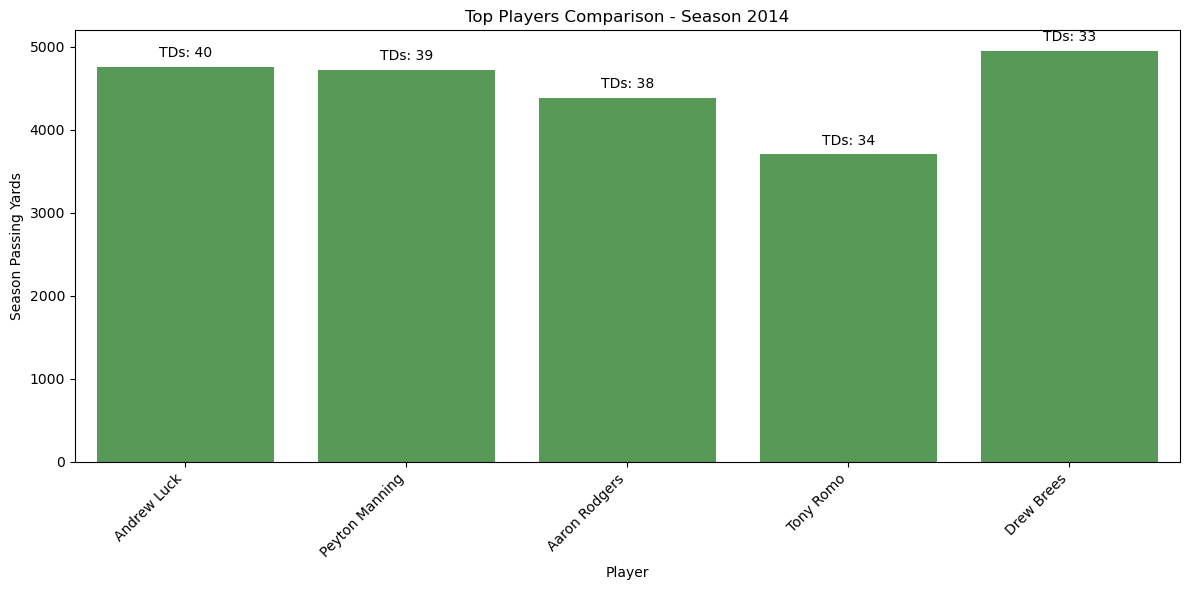

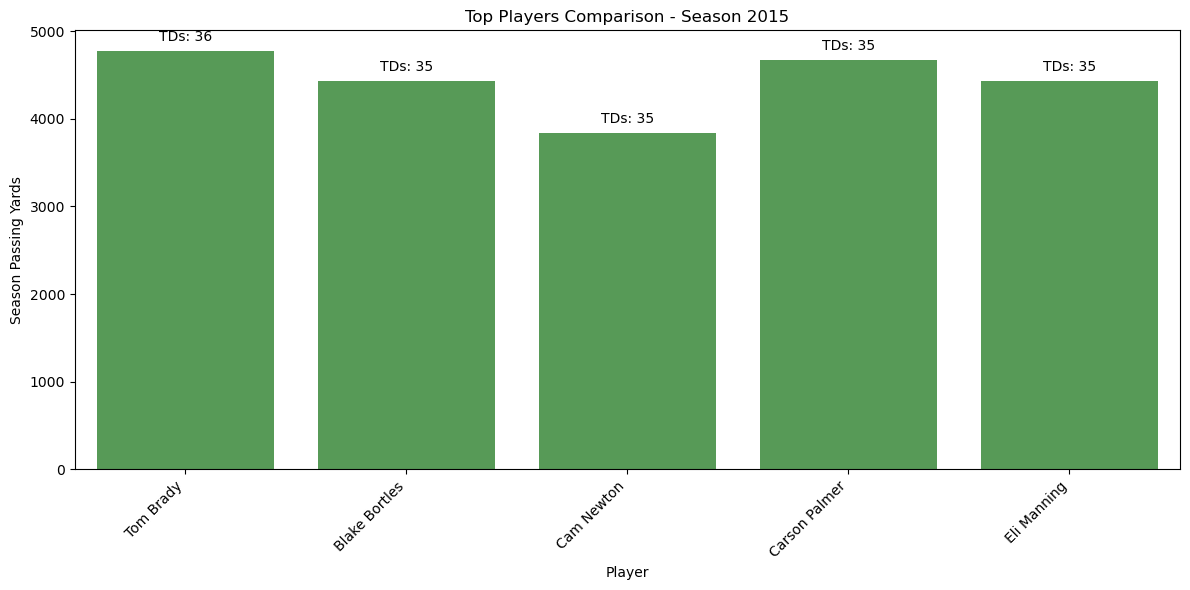

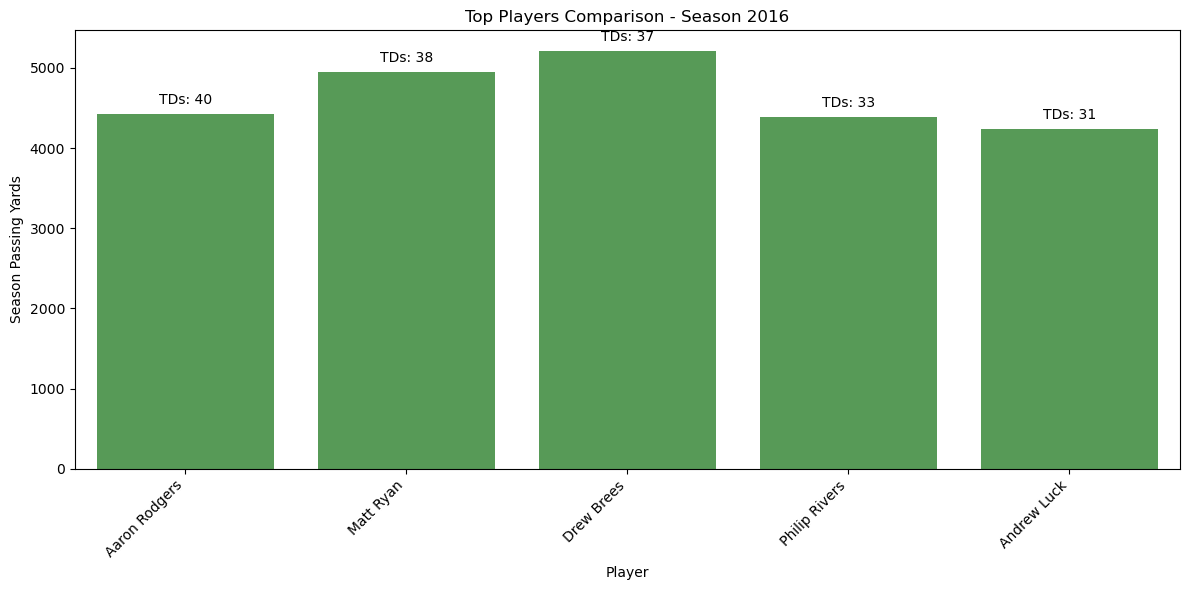

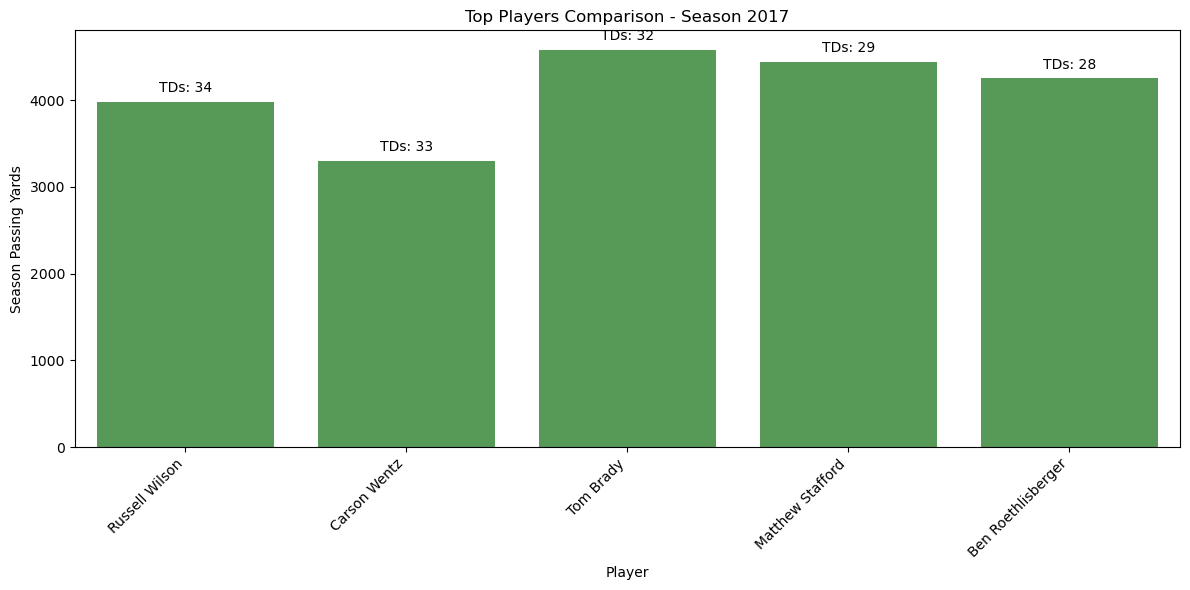

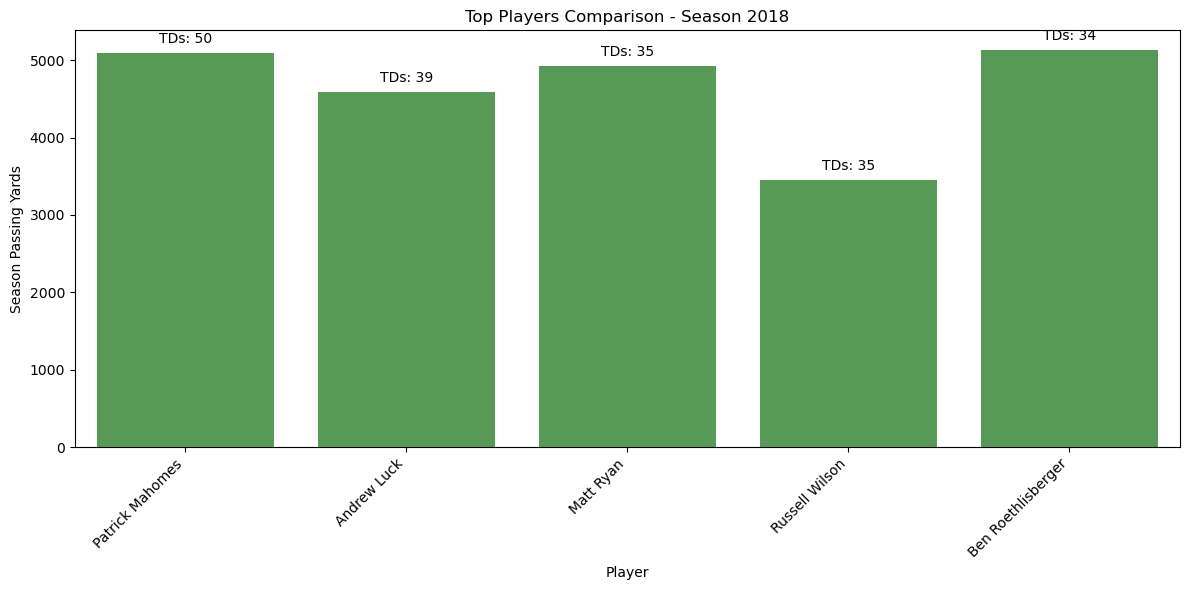

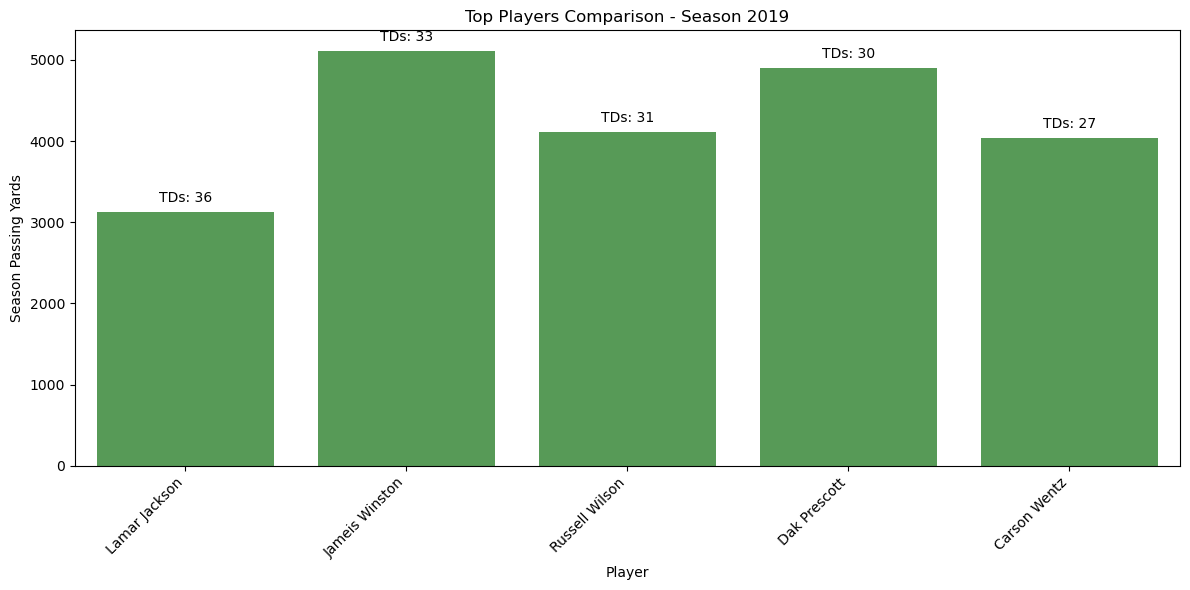

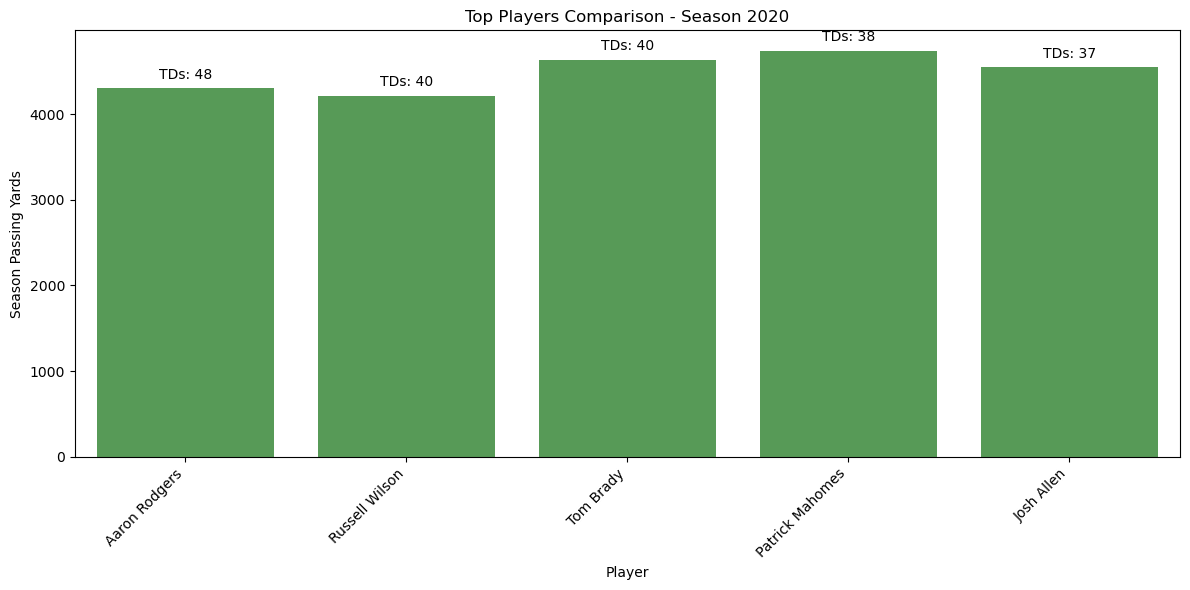

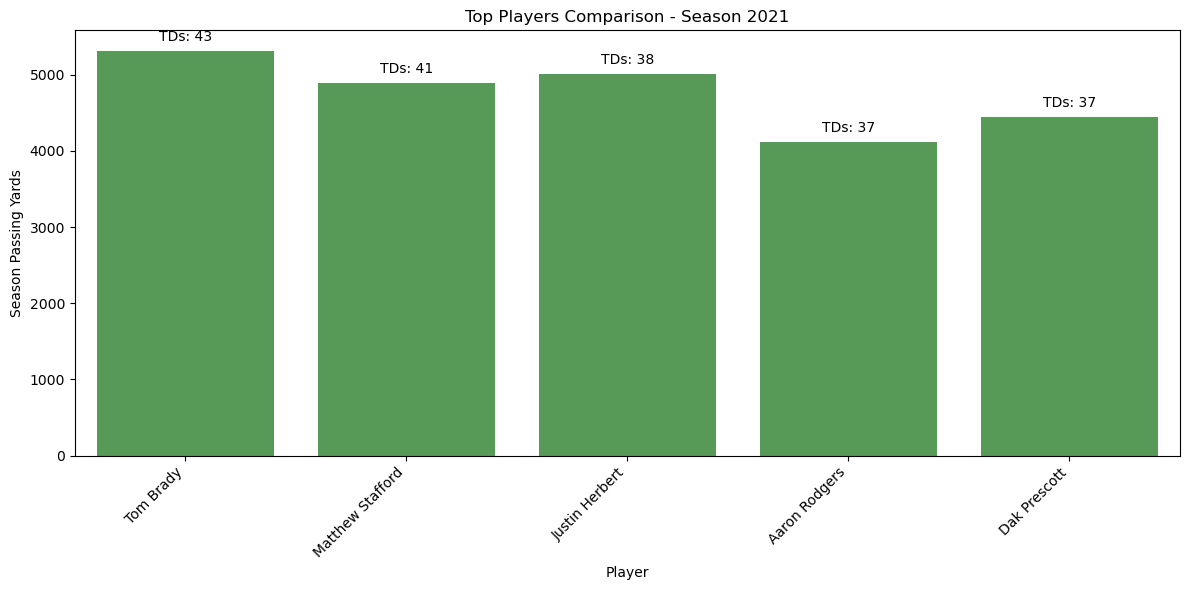

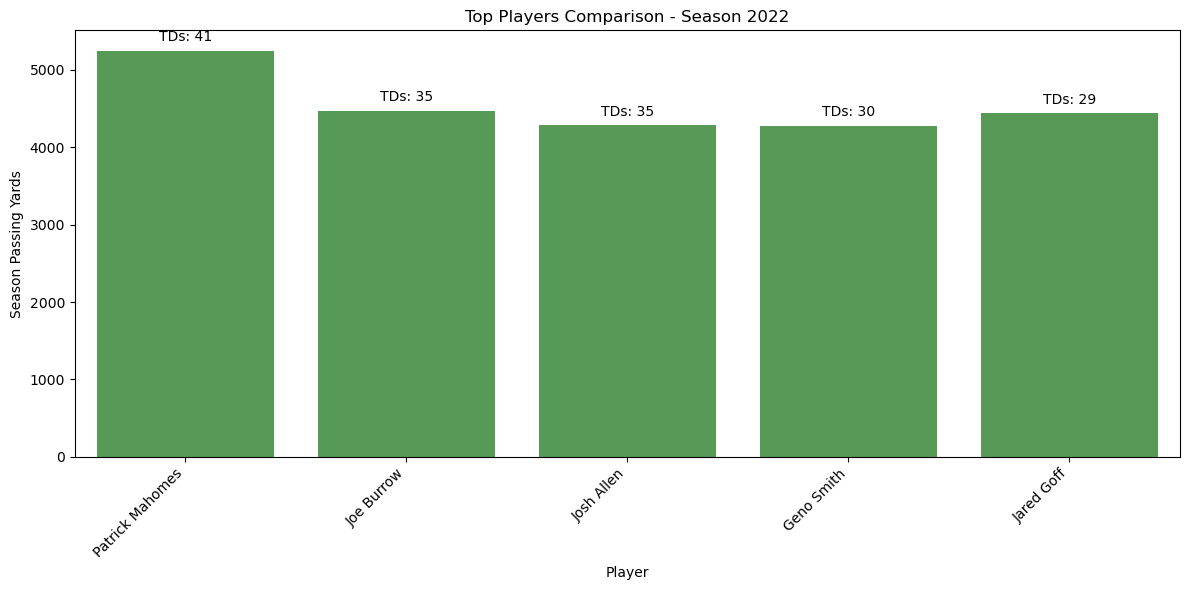

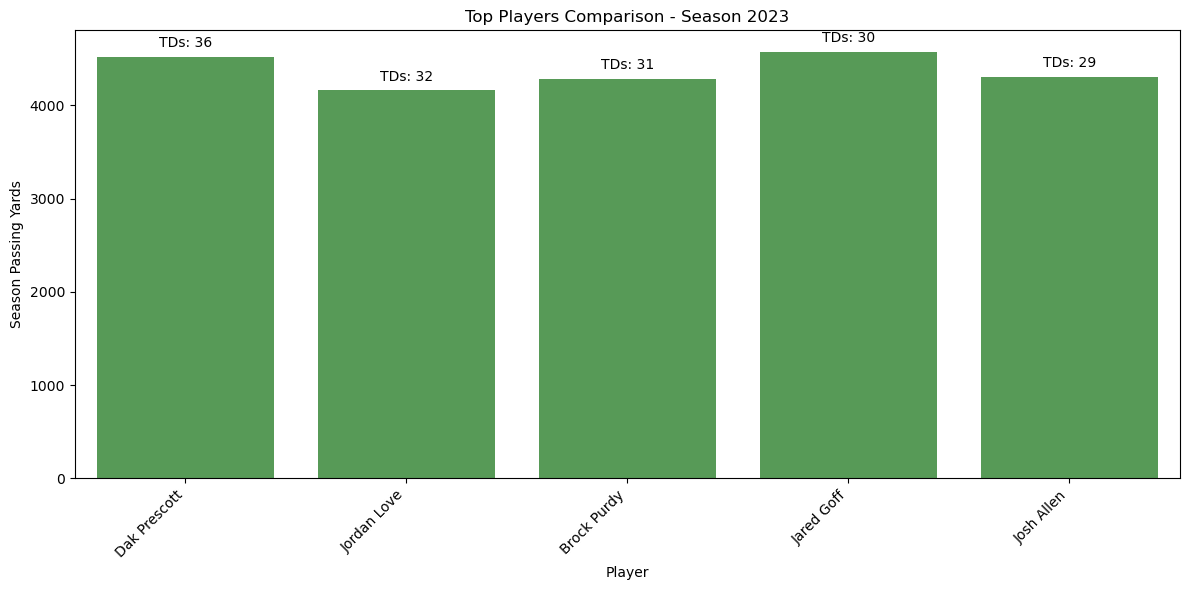

In [40]:
# Sort the DataFrame by 'season' and 'season_passing_tds' to get the top 5 players each season
top_players = qbs_df.groupby('season').apply(lambda x: x.nlargest(5, 'season_passing_tds')).reset_index(drop=True)

# Create a separate visualization for each season
for season, season_data in top_players.groupby('season'):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='player_display_name', y='season_passing_yards', data=season_data, color='green', alpha=0.7)
    for i, p in enumerate(ax.patches):
        tds = season_data.iloc[i]['season_passing_tds']
        ax.annotate(f'TDs: {tds}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title(f'Top Players Comparison - Season {season}')
    plt.xlabel('Player')
    plt.ylabel('Season Passing Yards')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Patrick Mahomes seems to be the best QB in recent years appear in the top 5 claiming the number one spot twice in the last 6 years

## Rushers

In [41]:
rushers_df.head()

,player_display_name,season,season_rushing_tds,season_rushing_yards,season_carries,season_yards_per_carry,season_tds_per_carry
1,A.J. Dillon,2021,5,803,187,4.195966,2.240896
2,A.J. Dillon,2022,7,770,186,4.165845,3.744801
3,A.J. Dillon,2023,2,613,178,3.370240,1.285714
5,Aaron Jones,2018,8,728,133,5.305956,5.058675
6,Aaron Jones,2019,16,1084,236,4.327544,6.656247


In [42]:
# Features (excluding the target and the player name)
X1 = rushers_df[['season', 'season_rushing_yards', 'season_carries', 
            'season_yards_per_carry', 'season_tds_per_carry']]
# Target variable
y1 = rushers_df['season_rushing_tds']

In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

### Dummy

In [44]:
# Initialize the dummy model
dummy1_model = DummyRegressor(strategy='mean')

# Train the model
dummy1_model.fit(X1_train, y1_train)

# Make predictions
y1_dummy_pred = dummy1_model.predict(X1_test)

# Calculate mean squared error
dummy1_mse = mean_squared_error(y1_test, y1_dummy_pred)
print(f'Dummy Model Mean Squared Error: {dummy1_mse}')

Dummy Model Mean Squared Error: 10.292423922231613


### Decision Tree

In [45]:
# Initialize the decision tree model
tree_model1 = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model1.fit(X1_train, y1_train)

# Make predictions
y1_tree_pred = tree_model1.predict(X1_test)

# Calculate mean squared error
tree_mse1 = mean_squared_error(y1_test, y1_tree_pred)
print(f'Decision Tree Model Mean Squared Error: {tree_mse1}')

Decision Tree Model Mean Squared Error: 1.9230769230769231


In [46]:
# Get feature importances
feature_importances1 = tree_model1.feature_importances_

# Create a DataFrame for better visualization
feature_importances1_df = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': feature_importances1
}).sort_values(by='Importance', ascending=False)

print(feature_importances1_df)


                  Feature  Importance
4    season_tds_per_carry    0.650189
1    season_rushing_yards    0.239607
2          season_carries    0.079863
3  season_yards_per_carry    0.024090
0                  season    0.006251


### Random Forest

In [47]:
# Cross-validation with RandomForest
rf_model1 = RandomForestRegressor(random_state=42)
cv_scores1 = cross_val_score(rf_model1, X1_train, y1_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error: {-cv_scores1.mean()}')

Cross-validated Mean Squared Error: 1.416522496194825


In [48]:
# Train the model on the entire dataset
rf_model1.fit(X1_train, y1_train)
importances1 = rf_model1.feature_importances_
feature_importances1_df = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': importances1
}).sort_values(by='Importance', ascending=False)
print(feature_importances1_df)

                  Feature  Importance
4    season_tds_per_carry    0.667268
1    season_rushing_yards    0.159887
2          season_carries    0.146672
3  season_yards_per_carry    0.019045
0                  season    0.007128


### Grid Search + Random Forest

In [49]:
# Set up the grid search
grid_search1 = GridSearchCV(estimator=rf_model1, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [50]:
# Perform the grid search
grid_search1.fit(X1_train, y1_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [51]:
# Get the best parameters
best_params1 = grid_search1.best_params_
print(f'Best parameters found: {best_params1}')

# Get the best estimator
best_rf_model1 = grid_search1.best_estimator_

# Train the best model on the entire dataset
best_rf_model1.fit(X1_train, y1_train)
importances_best1 = best_rf_model1.feature_importances_
feature_importances_best_df1 = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': importances_best1
}).sort_values(by='Importance', ascending=False)
print(feature_importances_best_df1)

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
                  Feature  Importance
4    season_tds_per_carry    0.667473
1    season_rushing_yards    0.167195
2          season_carries    0.142160
3  season_yards_per_carry    0.017613
0                  season    0.005559


In [52]:
# Make predictions with the best model
y1_best_pred = best_rf_model1.predict(X1_test)

# Calculate metrics
best_mse1 = mean_squared_error(y1_test, y1_best_pred)
best_rmse1 = mean_squared_error(y1_test, y1_best_pred, squared=False)
best_mae1 = mean_absolute_error(y1_test, y1_best_pred)
best_r21 = r2_score(y1_test, y1_best_pred)

print(f'Best Random Forest Model Mean Squared Error (MSE): {best_mse1}')
print(f'Best Random Forest Model Root Mean Squared Error (RMSE): {best_rmse1}')
print(f'Best Random Forest Model Mean Absolute Error (MAE): {best_mae1}')
print(f'Best Random Forest Model R-squared (R²): {best_r21}')

Best Random Forest Model Mean Squared Error (MSE): 0.895473015289406
Best Random Forest Model Root Mean Squared Error (RMSE): 0.9462943597472226
Best Random Forest Model Mean Absolute Error (MAE): 0.669277851117137
Best Random Forest Model R-squared (R²): 0.912260257943921


tds per carry and total yards no suprise there

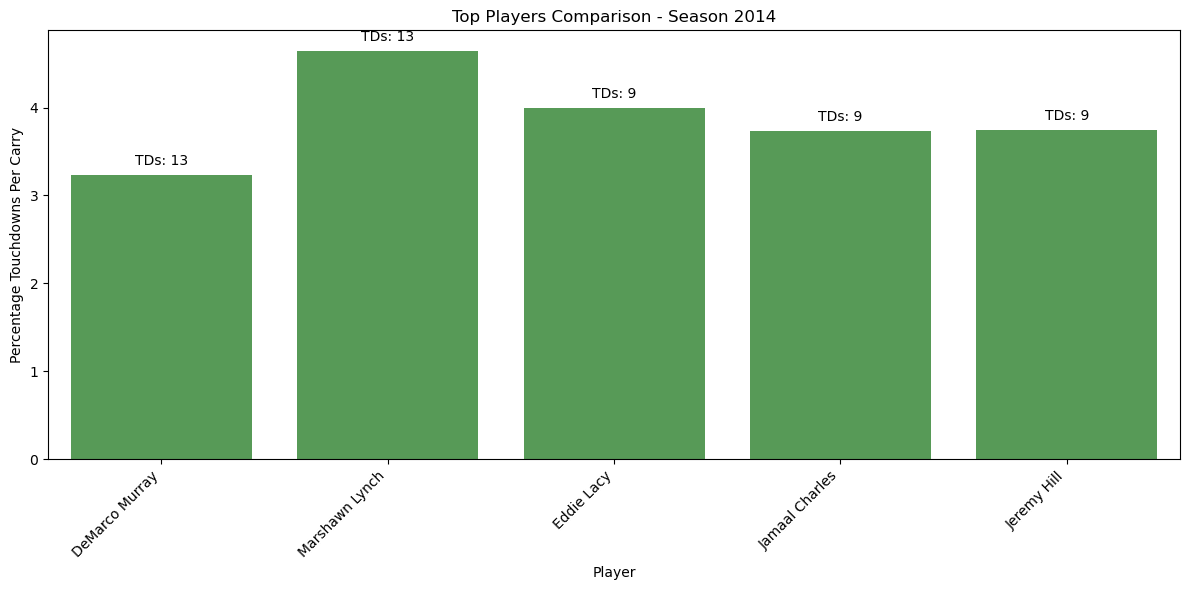

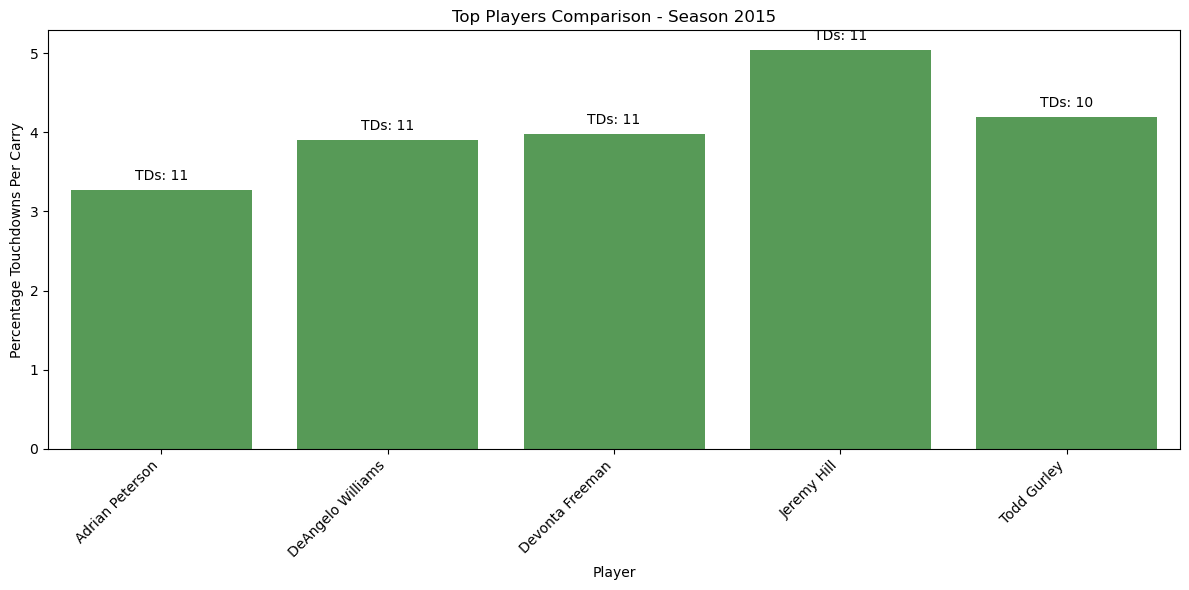

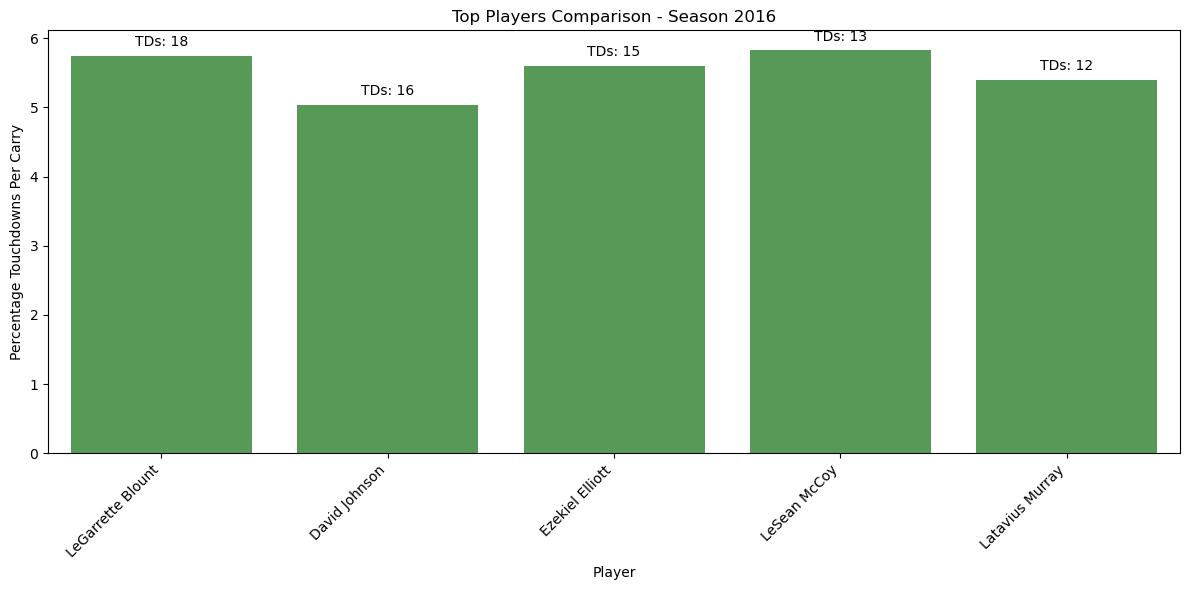

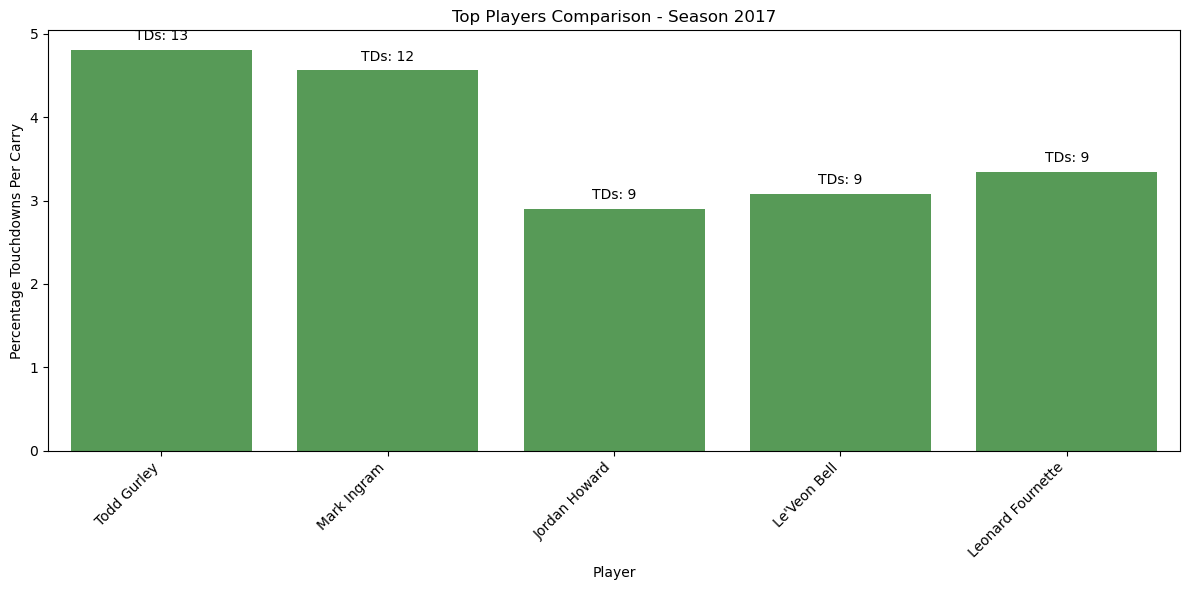

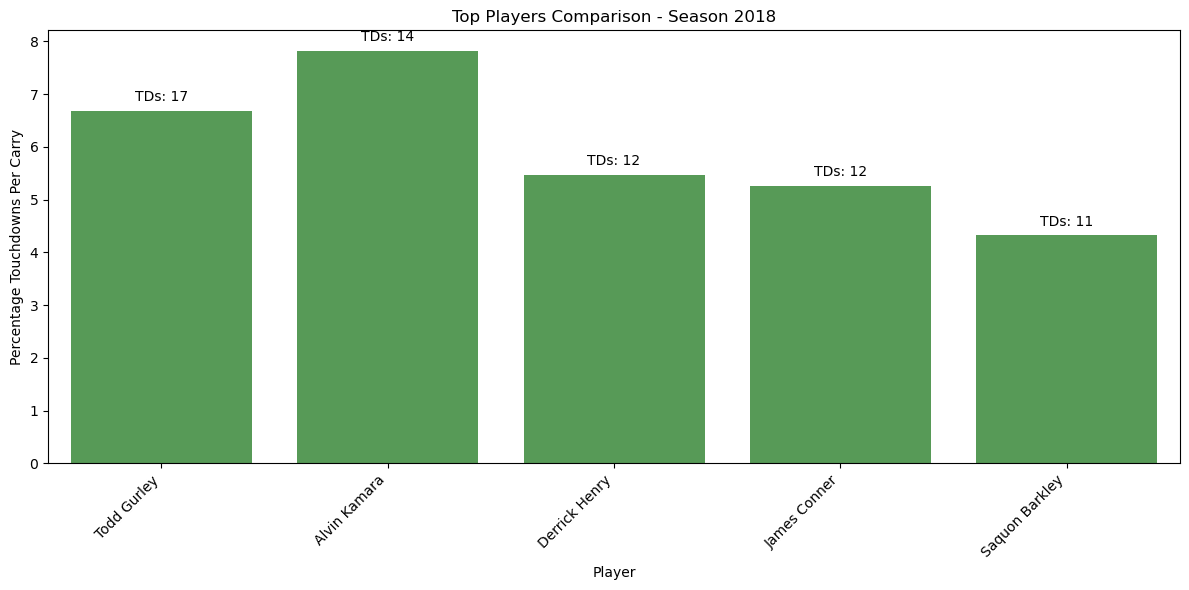

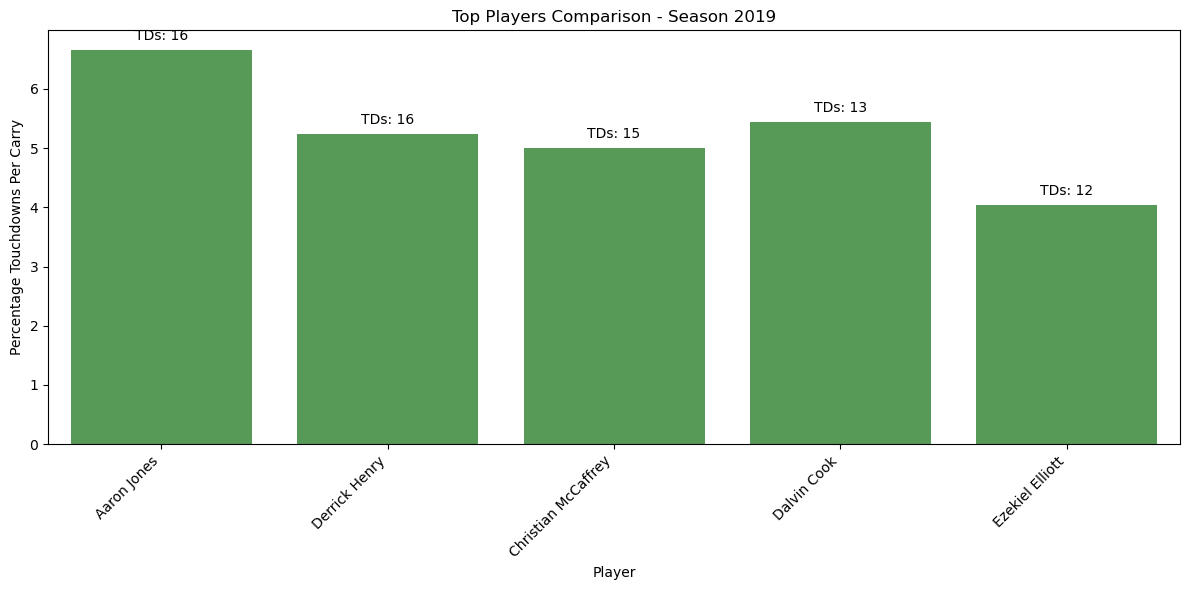

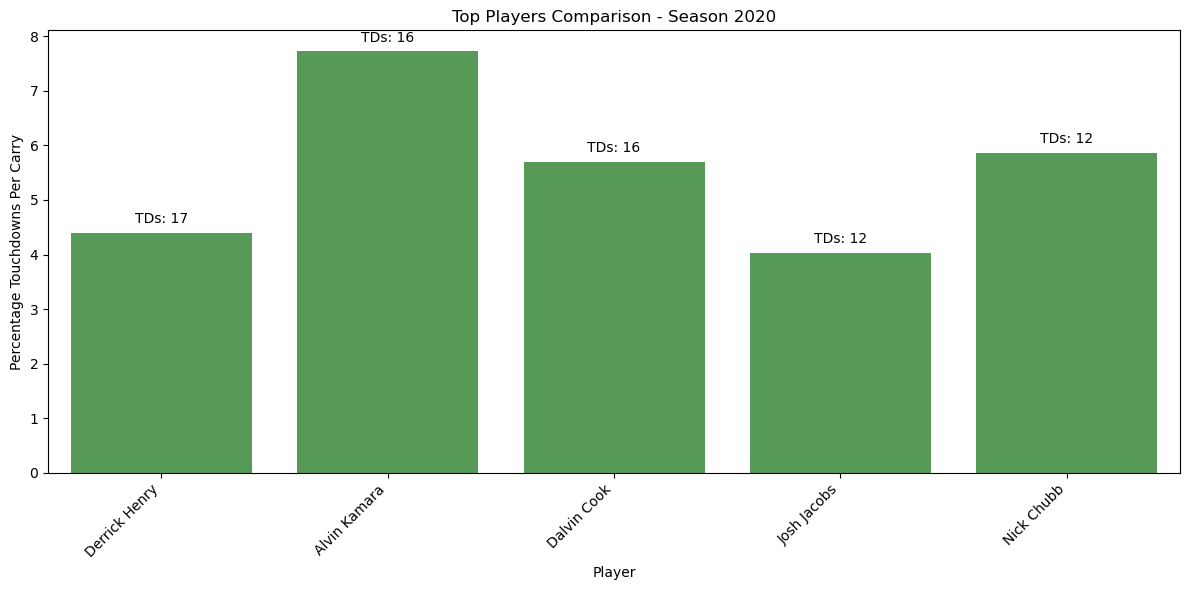

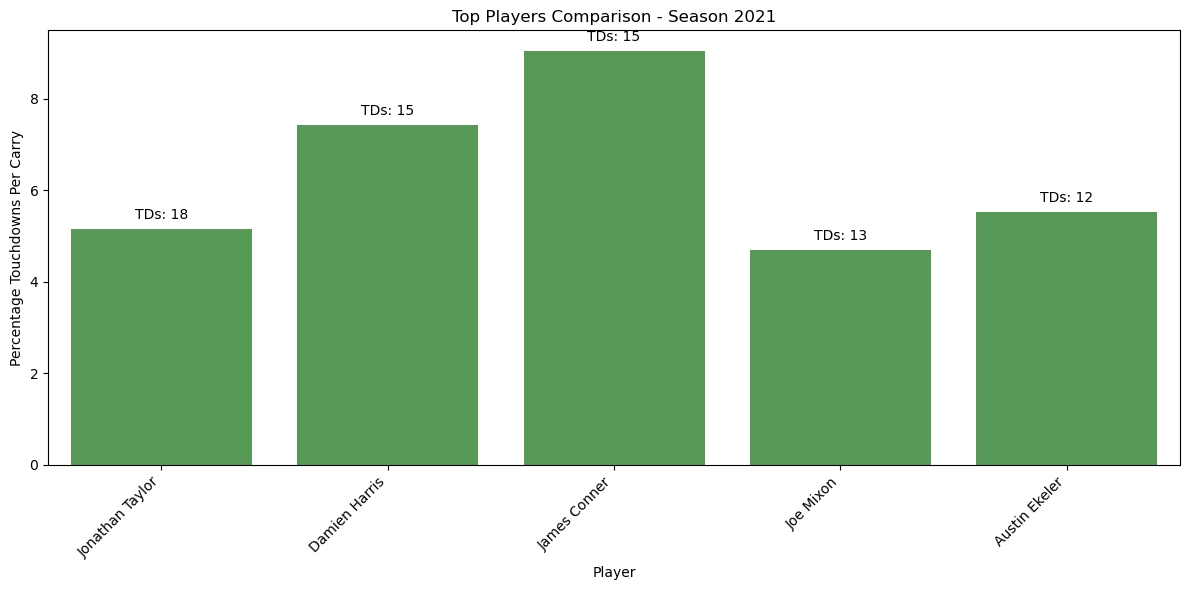

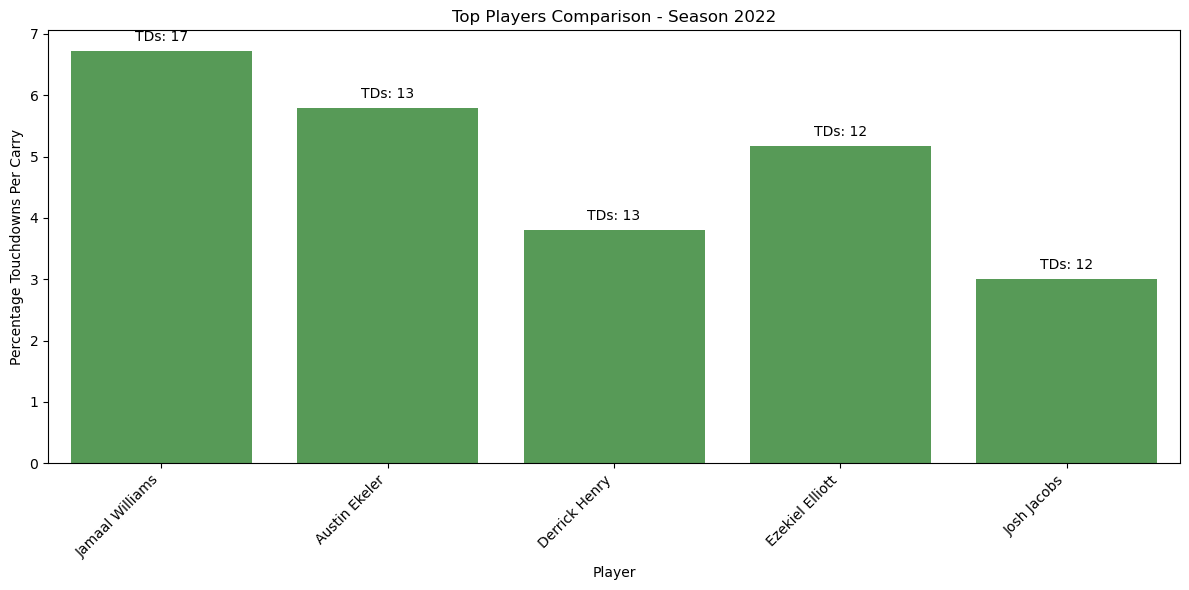

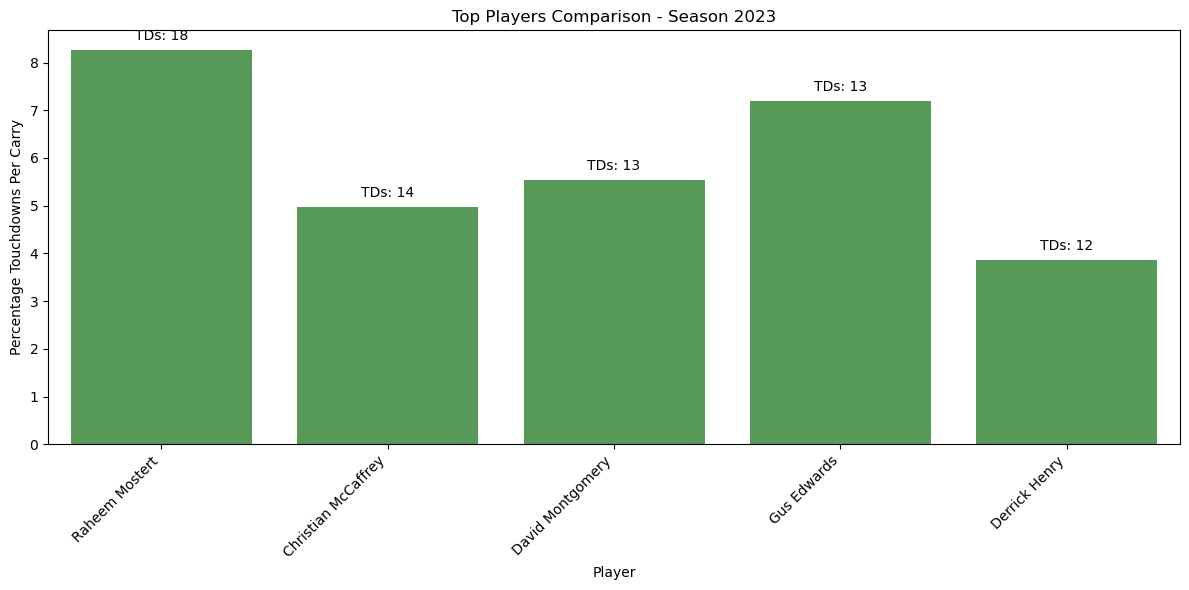

In [53]:
# Sort the DataFrame by 'season' and 'season_rushing_tds' to get the top 5 players each season
top_players1 = rushers_df.groupby('season').apply(lambda x: x.nlargest(5, 'season_rushing_tds')).reset_index(drop=True)

# Create a separate visualization for each season
for season, season_data in top_players1.groupby('season'):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='player_display_name', y='season_tds_per_carry', data=season_data, color='green', alpha=0.7)
    for i, p in enumerate(ax.patches):
        tds = season_data.iloc[i]['season_rushing_tds']
        ax.annotate(f'TDs: {tds}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title(f'Top Players Comparison - Season {season}')
    plt.xlabel('Player')
    plt.ylabel('Percentage Touchdowns Per Carry')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Derrick Henry is the most consistent RB in top 5. leading the pack in 2020, hes been top 5 in 5 of the last 6 years

## Receivers

In [54]:
receivers_df.head()

,player_display_name,season,season_receiving_yards,season_receiving_tds,season_receptions,season_yards_per_reception,season_tds_per_reception
3,A.J. Brown,2022,1496,11,88,16.368791,12.647059
4,A.J. Brown,2023,1456,7,106,12.863119,5.382820
9,A.J. Green,2015,1297,10,86,15.988014,11.089015
11,A.J. Green,2017,1078,8,75,13.566667,9.449405
25,Adam Humphries,2018,816,5,76,12.015923,5.580357


In [55]:
# Features (excluding the target and the player name)
X2 = receivers_df[['season', 'season_receiving_yards', 'season_receptions', 
            'season_yards_per_reception', 'season_tds_per_reception']]
# Target variable
y2 = receivers_df['season_receiving_tds']

In [56]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

### Dummy

In [57]:
# Initialize the dummy model
dummy2_model = DummyRegressor(strategy='mean')

# Train the model
dummy2_model.fit(X2_train, y2_train)

# Make predictions
y2_dummy_pred = dummy2_model.predict(X2_test)

# Calculate mean squared error
dummy2_mse = mean_squared_error(y2_test, y2_dummy_pred)
print(f'Dummy Model Mean Squared Error: {dummy2_mse}')

Dummy Model Mean Squared Error: 9.426912829498313


### Decision Tree

In [58]:
# Initialize the decision tree model
tree_model2 = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model2.fit(X2_train, y2_train)

# Make predictions
y2_tree_pred = tree_model2.predict(X2_test)

# Calculate mean squared error
tree_mse2 = mean_squared_error(y2_test, y2_tree_pred)
print(f'Decision Tree Model Mean Squared Error: {tree_mse2}')

Decision Tree Model Mean Squared Error: 3.34


In [59]:
# Get feature importances
feature_importances2 = tree_model2.feature_importances_

# Create a DataFrame for better visualization
feature_importances2_df = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': feature_importances2
}).sort_values(by='Importance', ascending=False)

print(feature_importances2_df)

                      Feature  Importance
4    season_tds_per_reception    0.762494
1      season_receiving_yards    0.125304
2           season_receptions    0.076144
3  season_yards_per_reception    0.028178
0                      season    0.007880


### Random Forest

In [60]:
# Cross-validation with RandomForest
rf_model2 = RandomForestRegressor(random_state=42)
cv_scores2 = cross_val_score(rf_model2, X2_train, y2_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error: {-cv_scores2.mean()}')

Cross-validated Mean Squared Error: 1.7495528461538463


In [61]:
# Train the model on the entire dataset
rf_model2.fit(X2_train, y2_train)
importances2 = rf_model2.feature_importances_
feature_importances2_df = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': importances2
}).sort_values(by='Importance', ascending=False)
print(feature_importances2_df)

                      Feature  Importance
4    season_tds_per_reception    0.777775
1      season_receiving_yards    0.095851
2           season_receptions    0.085280
3  season_yards_per_reception    0.028240
0                      season    0.012853


### Grid Search + Random Forest

In [62]:
# Set up the grid search
grid_search2 = GridSearchCV(estimator=rf_model2, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [63]:
# Perform the grid search
grid_search2.fit(X2_train, y2_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [64]:
# Get the best parameters
best_params2 = grid_search2.best_params_
print(f'Best parameters found: {best_params2}')

# Get the best estimator
best_rf_model2 = grid_search2.best_estimator_

# Train the best model on the entire dataset
best_rf_model2.fit(X2_train, y2_train)
importances_best2 = best_rf_model2.feature_importances_
feature_importances_best_df2 = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': importances_best2
}).sort_values(by='Importance', ascending=False)
print(feature_importances_best_df2)

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
                      Feature  Importance
4    season_tds_per_reception    0.789008
1      season_receiving_yards    0.091950
2           season_receptions    0.082995
3  season_yards_per_reception    0.024806
0                      season    0.011241


In [65]:
# Make predictions with the best model
y2_best_pred = best_rf_model2.predict(X2_test)

# Calculate metrics
best_mse2 = mean_squared_error(y2_test, y2_best_pred)
best_rmse2 = mean_squared_error(y2_test, y2_best_pred, squared=False)
best_mae2 = mean_absolute_error(y2_test, y2_best_pred)
best_r22 = r2_score(y2_test, y2_best_pred)

print(f'Best Random Forest Model Mean Squared Error (MSE): {best_mse2}')
print(f'Best Random Forest Model Root Mean Squared Error (RMSE): {best_rmse2}')
print(f'Best Random Forest Model Mean Absolute Error (MAE): {best_mae2}')
print(f'Best Random Forest Model R-squared (R²): {best_r22}')

Best Random Forest Model Mean Squared Error (MSE): 1.3252724007038383
Best Random Forest Model Root Mean Squared Error (RMSE): 1.1512047605460283
Best Random Forest Model Mean Absolute Error (MAE): 0.9032373881673884
Best Random Forest Model R-squared (R²): 0.8589475498420709


tds per reception and yards again. similar to rbs 

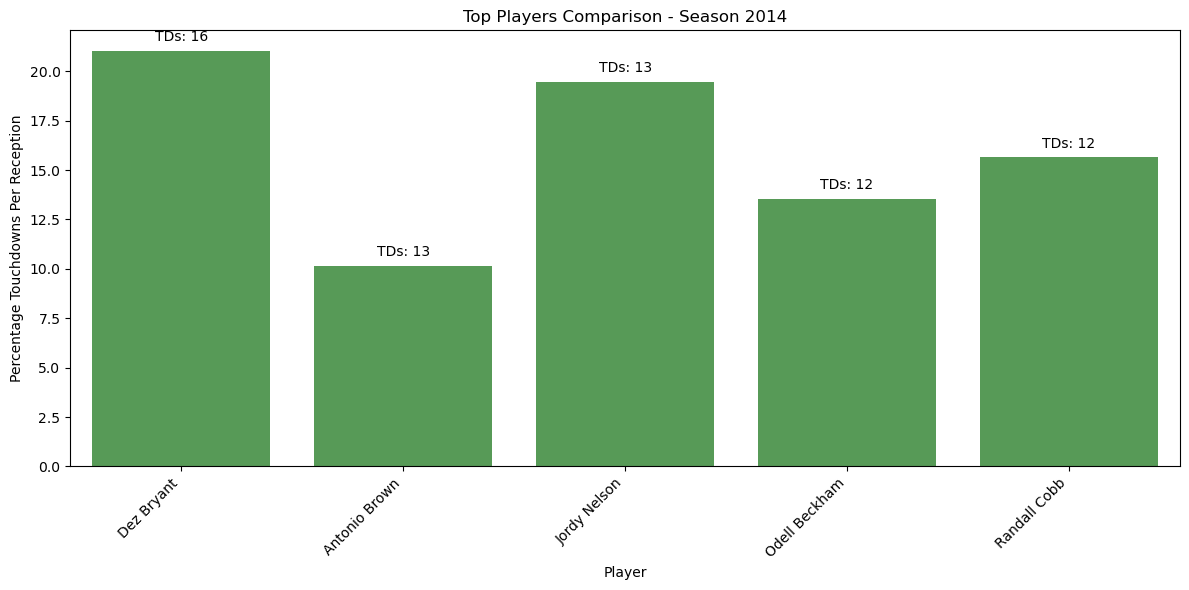

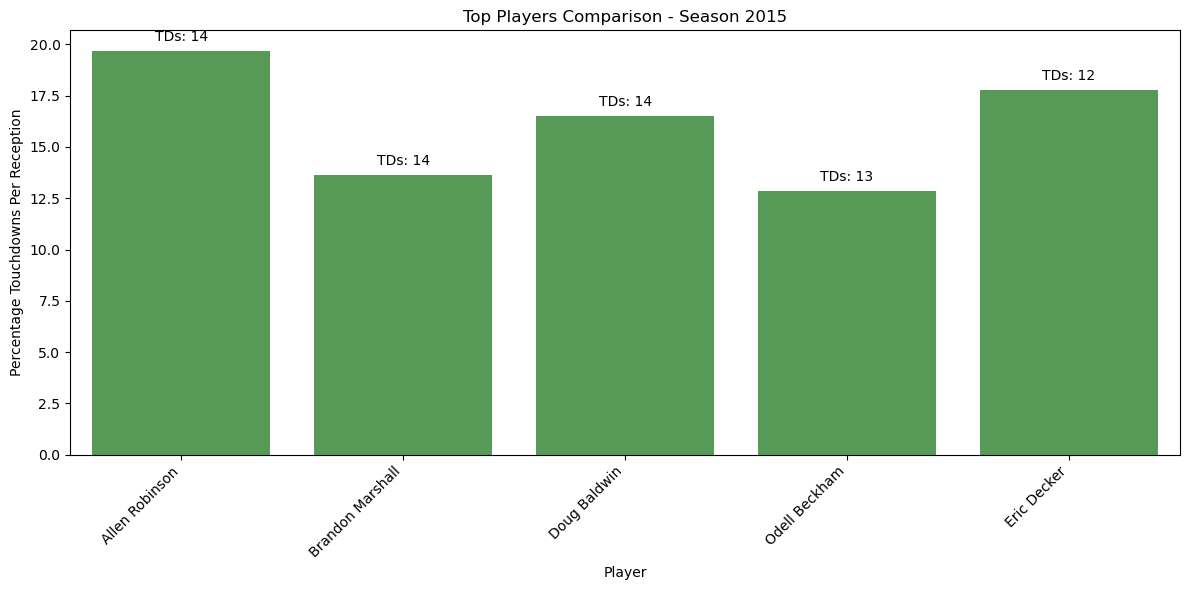

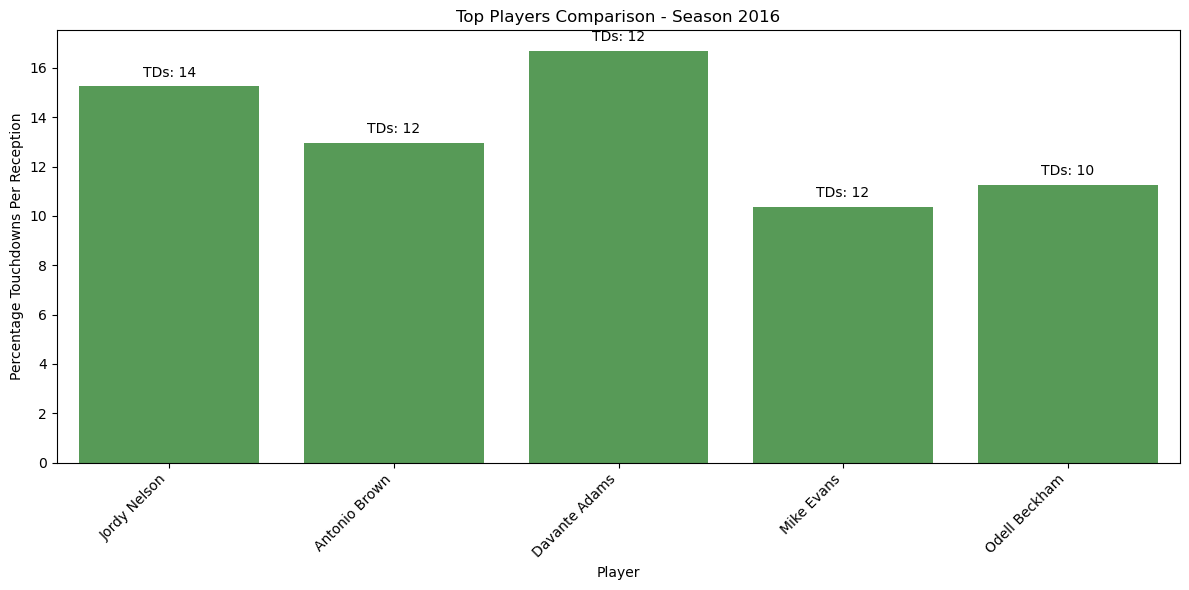

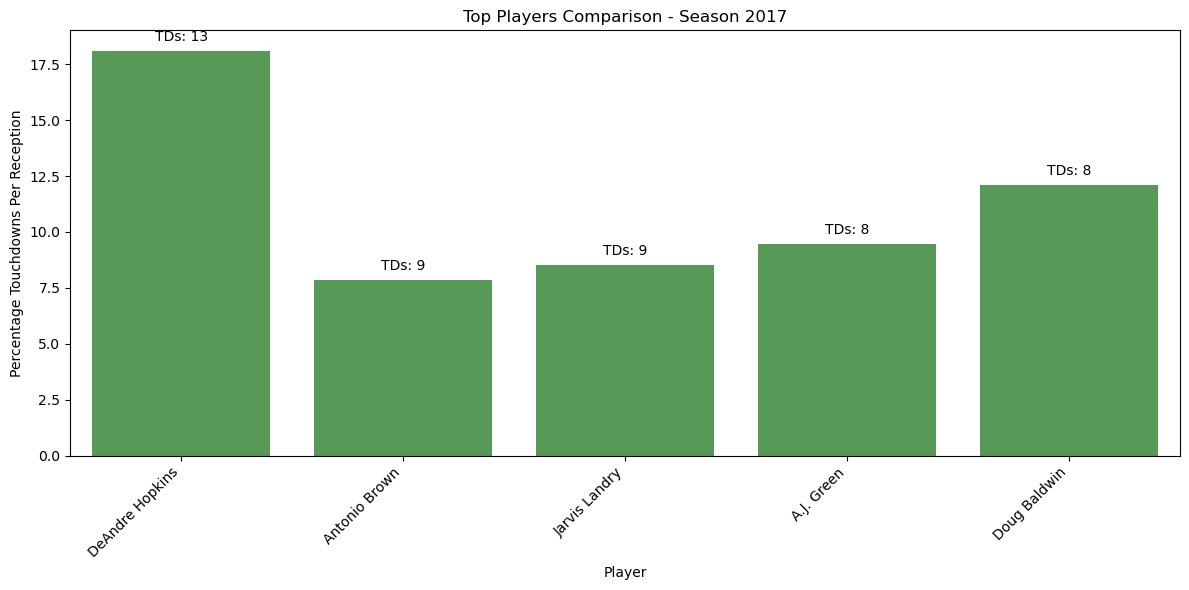

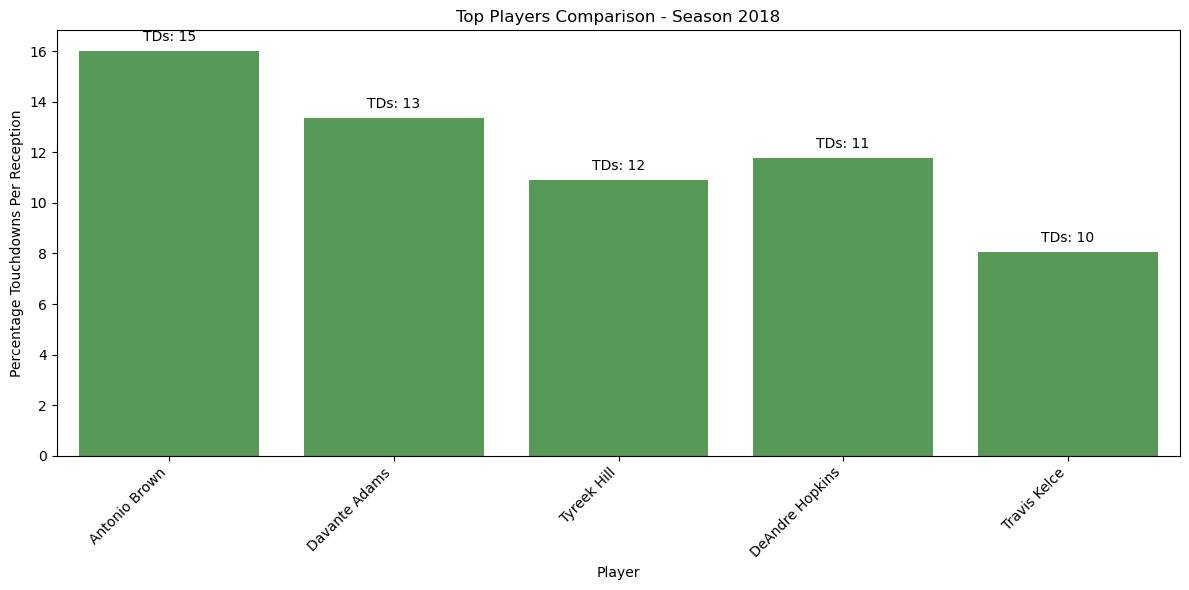

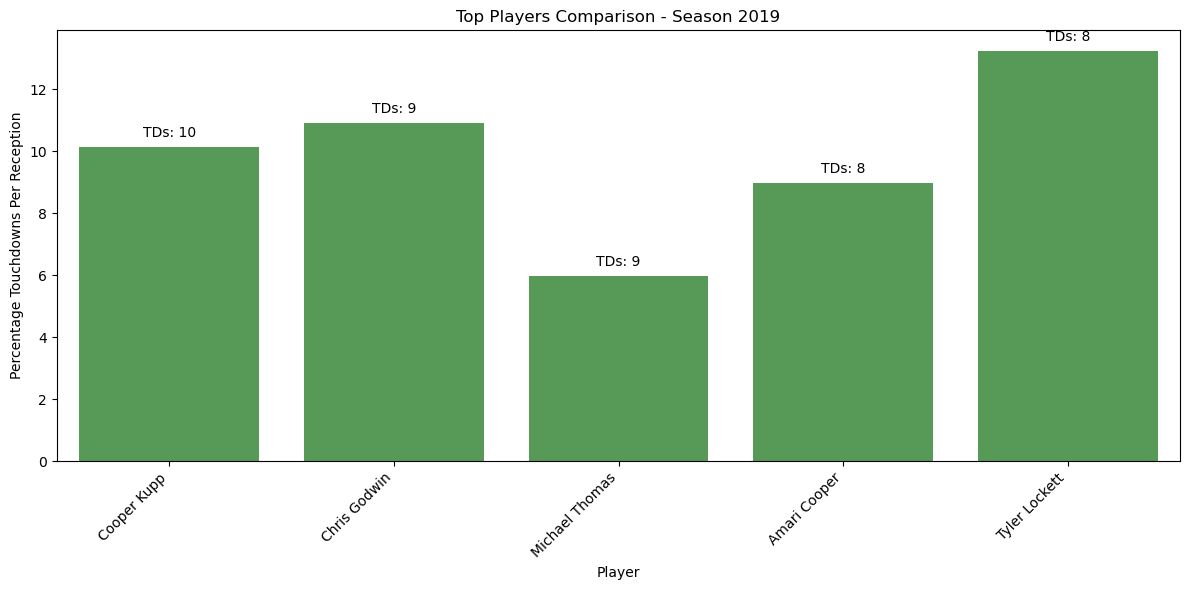

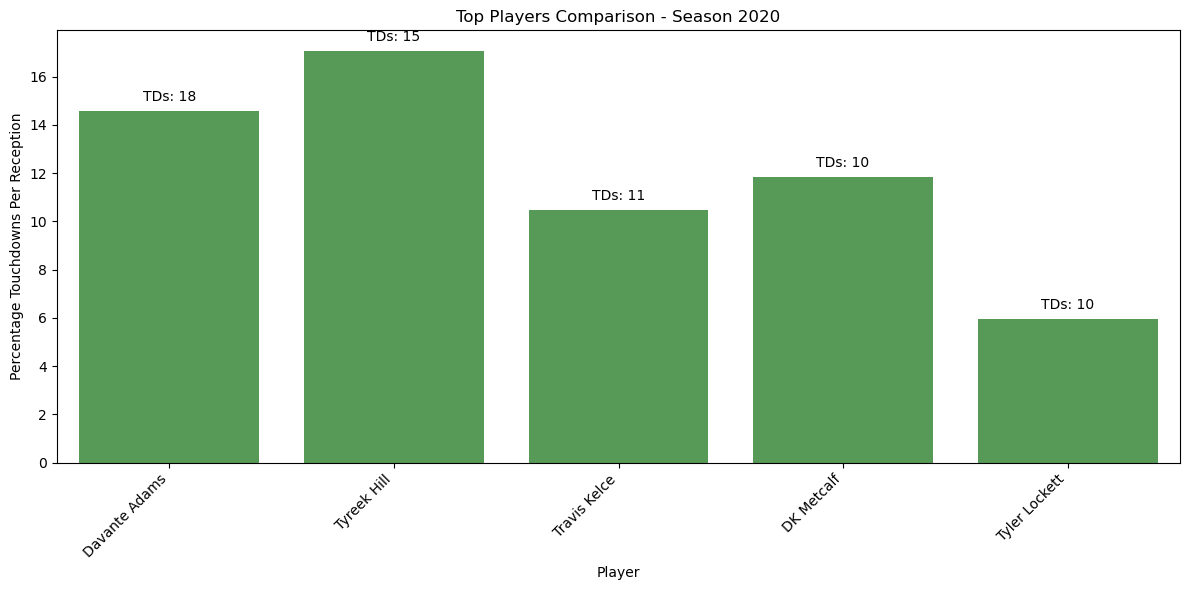

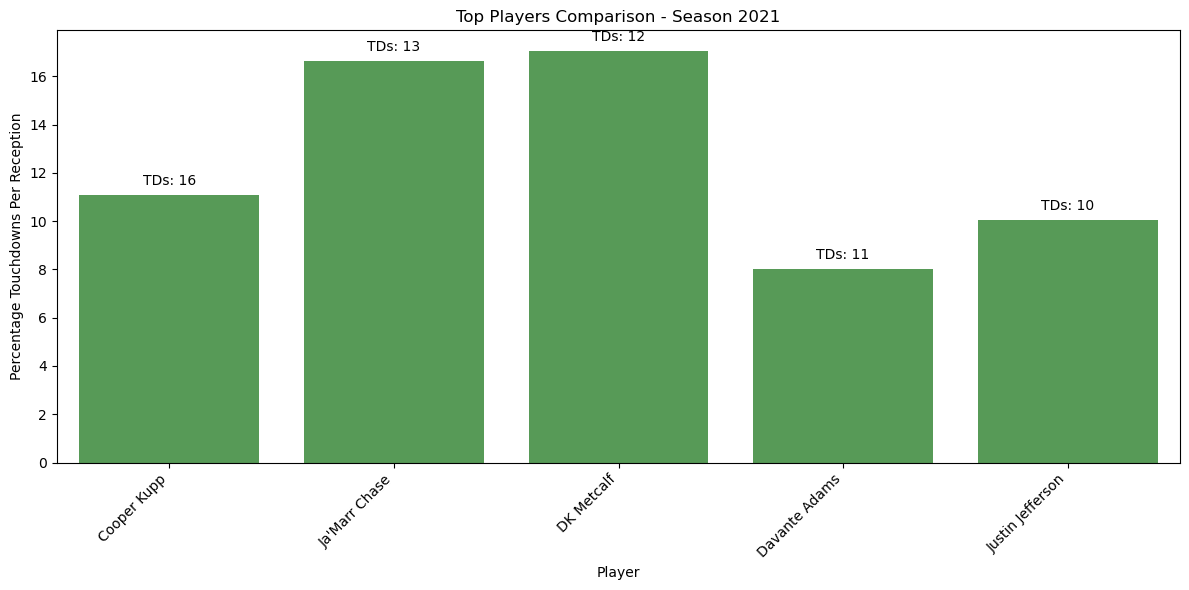

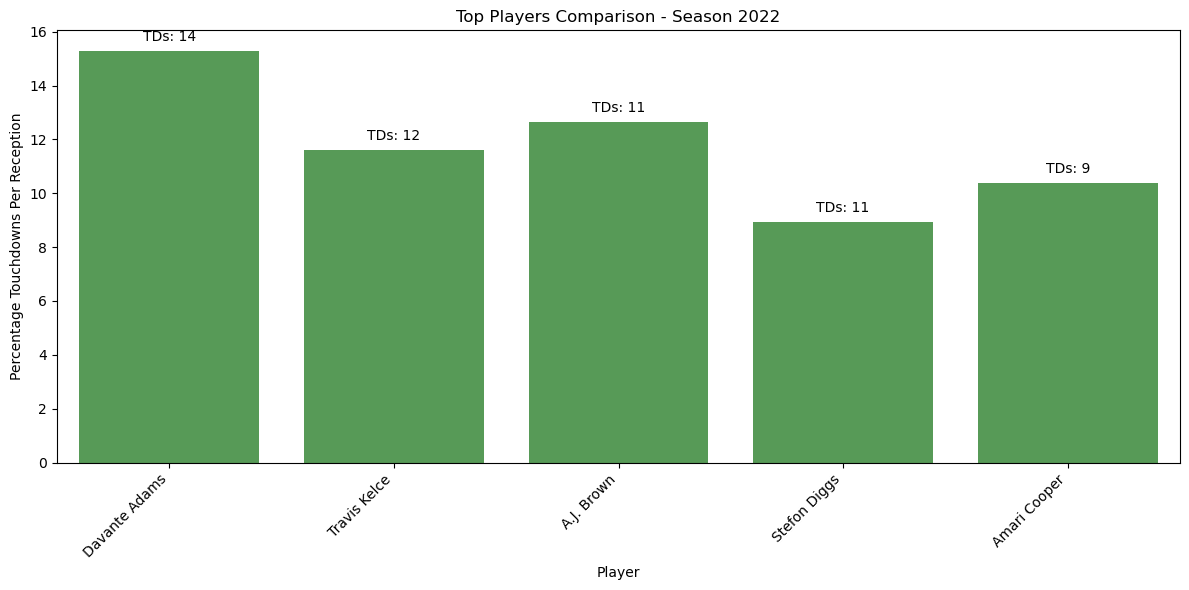

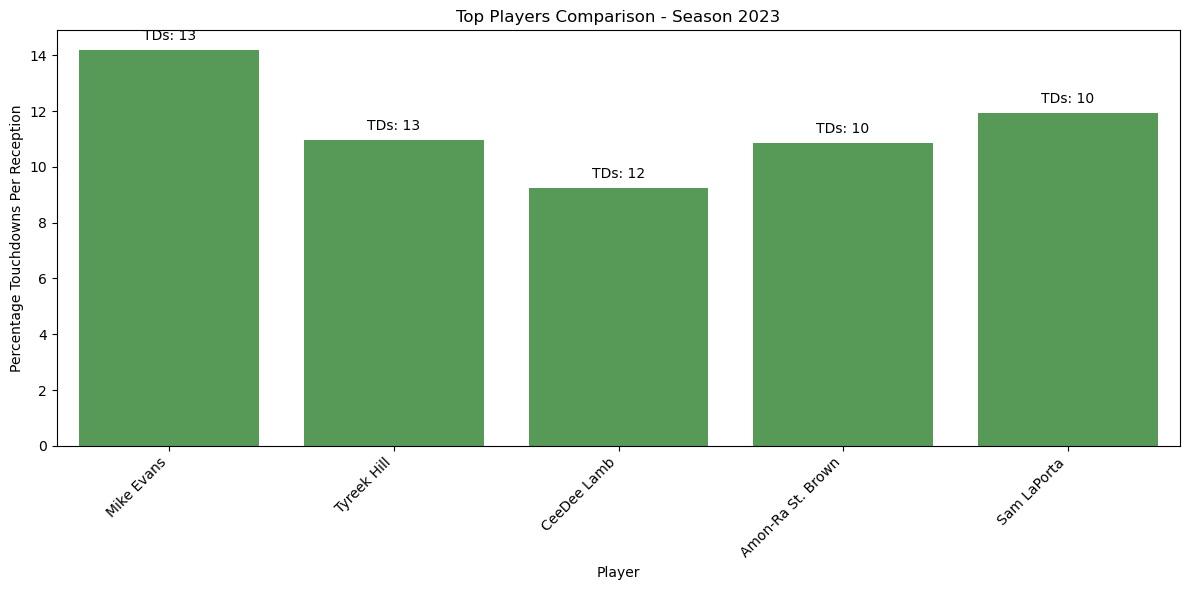

In [66]:
# Sort the DataFrame by 'season' and 'season_rushing_tds' to get the top 5 players each season
top_players2 = receivers_df.groupby('season').apply(lambda x: x.nlargest(5, 'season_receiving_tds')).reset_index(drop=True)

# Create a separate visualization for each season
for season, season_data in top_players2.groupby('season'):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='player_display_name', y='season_tds_per_reception', data=season_data, color='green', alpha=0.7)
    for i, p in enumerate(ax.patches):
        tds = season_data.iloc[i]['season_receiving_tds']
        ax.annotate(f'TDs: {tds}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title(f'Top Players Comparison - Season {season}')
    plt.xlabel('Player')
    plt.ylabel('Percentage Touchdowns Per Reception')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Davante Adams has been the most productive receiver. fairly consistent in top 5 and has led the league twice in the last 4 years
Travis Kelce also deserves a mention in the top 5 twice in the last 5 years as a tight end!